In [48]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action="ignore")

In [49]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [50]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker})).sort_values("date")
        price["average_return"] = price["adjclose"].pct_change(100)
        price["coev"] = price["adjclose"].rolling(100).std() / price["adjclose"].rolling(100).mean()
        prices.append(price.dropna())
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:02<00:00, 186.96it/s]


In [51]:
prices = pd.concat(prices).sort_values("date")

In [56]:
default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
cash = 100
portfolio = default_portfolio.copy()
portfolios = []
for date in tqdm(prices["date"].unique()):
    try:
        today = prices[prices["date"]==date]
        rec = today.sort_values("average_return",ascending=True).iloc[0]
        if portfolio["ticker"] == "":
            portfolio["ticker"] = rec["ticker"]
            portfolio["adjclose"] = rec["adjclose"]
            portfolio["quantity"] = cash / rec["adjclose"]
            portfolio["buy_price"] = rec["adjclose"]
            portfolio["date"] = date
            cash = 0
            portfolios.append(portfolio.copy())
        else:
            ## update
            updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
            portfolio["adjclose"] = updates["adjclose"]
            portfolio["date"] = date
            if rec["ticker"] != portfolio["ticker"]:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio["ticker"] = rec["ticker"]
                portfolio["adjclose"] = rec["adjclose"]
                portfolio["quantity"] = cash / rec["adjclose"]
                portfolio["buy_price"] = rec["adjclose"]
                portfolio["date"] = date
                cash = 0
                portfolios.append(portfolio.copy())
            else:
                portfolios.append(portfolio.copy())
    except Exception as e:
        print(str(e))
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 1066.86it/s]


In [57]:
states = pd.DataFrame(portfolios)
states["pv"] = states["adjclose"] * states["quantity"]
states["trade"] = states["ticker"] != states["ticker"].shift(-1)

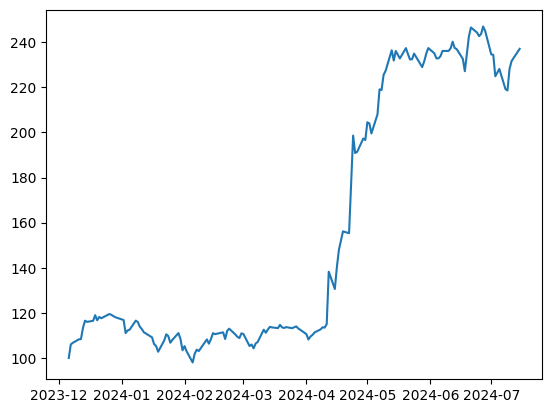

In [58]:
plt.plot(states["date"].values,states["pv"].values)

In [59]:
states[states["trade"]==True]

,ticker,adjclose,quantity,buy_price,date,pv,trade
0,ALB,118.30,0.845309,118.30,2023-12-06,100.000000,True
11,PAYC,206.60,0.571950,185.26,2023-12-21,118.164835,True
12,FMC,62.74,1.874289,62.74,2023-12-22,117.592885,True
13,PAYC,206.32,0.579038,206.32,2023-12-26,119.467174,True
15,FMC,63.31,1.871796,63.63,2023-12-28,118.503405,True
21,PAYC,204.14,0.570901,206.72,2024-01-08,116.543812,True
27,FMC,55.47,1.912930,60.59,2024-01-17,106.110203,True
29,ALB,115.13,0.892344,117.99,2024-01-19,102.735540,True
30,FMC,56.40,1.910470,56.40,2024-01-22,107.750512,True
44,ALB,115.78,0.901080,122.59,2024-02-09,104.327026,True
